## Train Hand Classifier

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import matplotlib.pyplot as plt
import cv2
from math import ceil
import sys
import time

Packages versions:

In [2]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)

Python: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
PyTorch: 1.11.0


**Initial configurations**

In [3]:
# define model id
model_id = 'classification_model_05'

# define images path
images_folder = './data/letters'

Data preparation:

In [4]:
# read data
dataset = ImageFolder(images_folder, transform = transforms.Compose([
    transforms.Resize((64, 64)), transforms.ToTensor()
]))

In [5]:
# print classes and size of dataset
classes = dataset.classes
print('Classes:', classes)
print('Number of classes:', len(classes))
dataset_size = len(dataset)
print('Size of dataset:', dataset_size)

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
Number of classes: 21
Size of dataset: 49551


In [6]:
# splitting data into train, val and test
val_size = ceil(dataset_size * 0.2)
test_size = ceil(dataset_size * 0.2)
train_size = len(dataset) - val_size - test_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], torch.Generator().manual_seed(74))

print('* Sizes after splitting *')
print('Train:', train_size)
print('Validation:', val_size)
print('Test:', test_size)

* Sizes after splitting *
Train: 29729
Validation: 9911
Test: 9911


In [7]:
# load the datasets into batches
batch_size = 50
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 0, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 0, pin_memory = True)

Create classes and functions for training:

In [8]:
# create base class for model training
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)  # predictions
        loss = F.cross_entropy(out, labels) # loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images) # predictions
        loss = F.cross_entropy(out, labels) # loss
        acc = accuracy(out, labels) # accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # mean of loss
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # mean of accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        train_loss = round(result['train_loss'], 4)
        val_loss = round(result['val_loss'], 4)
        val_acc = round(result['val_acc'], 4)
        print(f'Epoch [{epoch}], train_loss: {train_loss}, val_loss: {val_loss}, val_acc: {val_acc}')

In [9]:
# define accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
# architecture of CNN model
class HandGestureClassification(ImageClassificationBase):
    
    def __init__(self):

        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(16384, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 21)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [11]:
# define device
def get_default_device():
    # set device to GPU or CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    # mode data to device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        # number of batches
        return len(self.dl)

In [12]:
# model fitting
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [13]:
# define plots
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation Accuracy')
    plt.savefig(f'./outputs/plots/accuracies_{model_id}.png')

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Train and Validation Losses')
    plt.savefig(f'./outputs/plots/losses_{model_id}.png')

**Training the model**

In [14]:
# define device and load data
device = get_default_device()
print('Device:', device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# load the model to the device
model = to_device(HandGestureClassification(), device)

Device: cuda


In [15]:
# define hyperparameters
epochs = 30
lr = 0.01
opt_func = torch.optim.SGD

In [16]:
# fit
start_time = time.time()
model_result = fit(epochs = epochs, lr = lr, model = model, train_loader = train_dl, val_loader = val_dl, opt_func = opt_func)
end_time = time.time()
print(f'Total time: {(end_time - start_time)/60:.3} min')

Epoch [0], train_loss: 3.0447, val_loss: 3.0448, val_acc: 0.0502
Epoch [1], train_loss: 3.0445, val_loss: 3.0449, val_acc: 0.0502
Epoch [2], train_loss: 3.0443, val_loss: 3.045, val_acc: 0.0502
Epoch [3], train_loss: 3.0443, val_loss: 3.0451, val_acc: 0.0502
Epoch [4], train_loss: 3.0442, val_loss: 3.0451, val_acc: 0.0502
Epoch [5], train_loss: 3.0442, val_loss: 3.0451, val_acc: 0.0502
Epoch [6], train_loss: 3.0442, val_loss: 3.0452, val_acc: 0.0502
Epoch [7], train_loss: 3.0442, val_loss: 3.0452, val_acc: 0.0502
Epoch [8], train_loss: 3.0441, val_loss: 3.0452, val_acc: 0.0502
Epoch [9], train_loss: 3.0441, val_loss: 3.0451, val_acc: 0.0502
Epoch [10], train_loss: 3.0441, val_loss: 3.0451, val_acc: 0.052
Epoch [11], train_loss: 3.044, val_loss: 3.0451, val_acc: 0.0673
Epoch [12], train_loss: 3.044, val_loss: 3.045, val_acc: 0.0502
Epoch [13], train_loss: 3.0439, val_loss: 3.0449, val_acc: 0.0712
Epoch [14], train_loss: 3.0437, val_loss: 3.0447, val_acc: 0.0713
Epoch [15], train_loss: 3

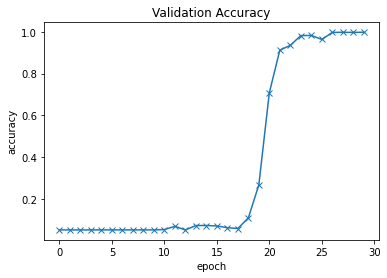

In [17]:
# plot accuracy
plot_accuracies(model_result)

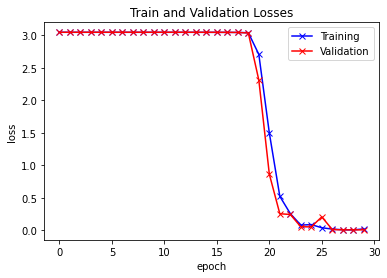

In [18]:
# plot loss
plot_losses(model_result)

In [19]:
# save model
model_path = f'./outputs/models/{model_id}.pth'
torch.save(model.state_dict(), model_path)

In [20]:
# save results
result_list = ['Model ID:', model_id, '\n',
               'Path to model:', model_path, '\n',
               'Model architecture:', str(model), '\n',
               'Hyperparameters:', '- Epochs:', str(epochs), '- Learning rate:', str(lr), '- Optimization function:', str(opt_func), '\n',
               'Evaluation:', str(model_result[-1])]

textfile = open(f'./outputs/results/results_{model_id}.txt', 'w')
for element in result_list:
    textfile.write(element + "\n")
textfile.close()

Execute all the step until here to generate a experiment. Execute a number of experiments changing hyperparameters and model architecture. Compare all experiments using validation accuracy. Use the best hyperparameter and architecture setting to execute the next steps and save final model.

**Get the final model**

In [21]:
# change model ID
model_id = 'final_classification_model'

In [22]:
# merge train and validation datasets
full_train = ConcatDataset([train_data, val_data])

In [23]:
# load the datasets into batches
full_train_dl = DataLoader(full_train, batch_size, shuffle = True, num_workers = 0, pin_memory = True)
test_dl = DataLoader(test_data, batch_size, num_workers = 0, pin_memory = True)

In [24]:
# final architecture of CNN model
class HandGestureClassificationFinal(ImageClassificationBase):
    
    def __init__(self):

        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(16384, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 21)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [25]:
# load data
full_train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(val_dl, device)

# load the model to the device
final_model = to_device(HandGestureClassificationFinal(), device)

In [26]:
# define hyperparameters
epochs = 30
lr = 0.01
opt_func = torch.optim.SGD

In [27]:
# fit
start_time = time.time()
final_model_result = fit(epochs = epochs, lr = lr, model = final_model, train_loader = full_train_dl, val_loader = test_dl, opt_func = opt_func)
end_time = time.time()
print(f'Total time: {(end_time - start_time)/60:.3} min')

Epoch [0], train_loss: 3.0449, val_loss: 3.0446, val_acc: 0.0503
Epoch [1], train_loss: 3.0446, val_loss: 3.0447, val_acc: 0.0438
Epoch [2], train_loss: 3.0444, val_loss: 3.0448, val_acc: 0.0438
Epoch [3], train_loss: 3.0442, val_loss: 3.0449, val_acc: 0.0438
Epoch [4], train_loss: 3.0442, val_loss: 3.045, val_acc: 0.0438
Epoch [5], train_loss: 3.0441, val_loss: 3.045, val_acc: 0.0459
Epoch [6], train_loss: 3.044, val_loss: 3.045, val_acc: 0.0459
Epoch [7], train_loss: 3.0439, val_loss: 3.0449, val_acc: 0.0635
Epoch [8], train_loss: 3.0438, val_loss: 3.0447, val_acc: 0.0561
Epoch [9], train_loss: 3.0436, val_loss: 3.0444, val_acc: 0.0509
Epoch [10], train_loss: 3.0431, val_loss: 3.0437, val_acc: 0.0502
Epoch [11], train_loss: 3.0419, val_loss: 3.0416, val_acc: 0.0715
Epoch [12], train_loss: 3.0248, val_loss: 2.9021, val_acc: 0.1155
Epoch [13], train_loss: 2.2619, val_loss: 2.1271, val_acc: 0.3335
Epoch [14], train_loss: 1.2744, val_loss: 0.8288, val_acc: 0.7148
Epoch [15], train_loss: 

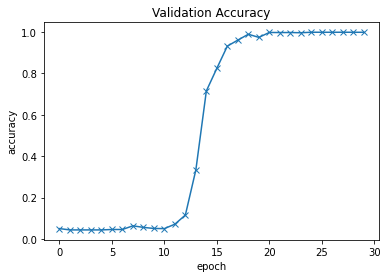

In [28]:
# plot accuracy
plot_accuracies(final_model_result)

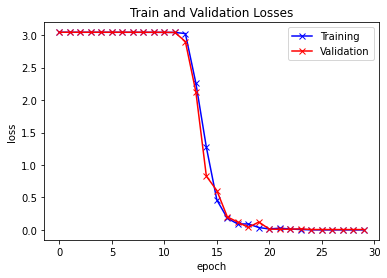

In [29]:
# plot loss
plot_losses(final_model_result)

In [30]:
# evaluate the model in test data
result = evaluate(final_model, test_dl)
print(result)

{'val_loss': 0.005749234929680824, 'val_acc': 0.9980904459953308}


In [31]:
# save model
model_path = f'./outputs/models/{model_id}.pth'
torch.save(final_model.state_dict(), model_path)

**Prediction for an image**

In [32]:
def predict_img_class(img,model):
    img = to_device(img.unsqueeze(0), device)
    prediction = model(img)
    _, preds = torch.max(prediction, dim = 1)
    prob = torch.max(F.softmax(prediction, dim = 1)).item()
    return [dataset.classes[preds[0].item()], prob]

Predicted class: B
Confidence: 0.9999984502792358


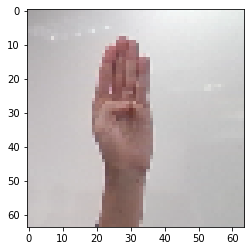

In [38]:
# get image path
file_path = './data/letters/B/B (2100).png'

# display image and prediction
img = cv2.imread(file_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (4, 4))
plt.imshow(img)

img_tensor = transforms.ToTensor()(img)

prediction = predict_img_class(img_tensor, final_model)
print(f'Predicted class: {prediction[0]}')
print(f'Confidence: {prediction[1]}')